# Using NLP to Identify Consumer Sentiment on Twitter

Analysis and model by Amanda Potter and Adam Roth

## Introduction

Twitter users generate millions of tweets everyday, and much of this is aimed at a particular product or brand.  Companies need to find quick and effective ways to sort through the millions of tweets and identify those that indicate unhappy consumers to that they can quickly respond before the negative experience is amplified across media and the company risks losing customers.  It is also important that companies are able to correctly identify positive brand sentiment so that those tweets can be amplified across social media. 

## Goal¶

This project seeks to develop a model to classify a tweet as having positive or negative sentiment.  Using a set of actual tweets, our model will use Natural Language Processing

## Data

The data for this project can be found at https://data.world/crowdflower/brands-and-product-emotions
In this dataset, contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion

## Table of contents:

- Imports
- EDA
- Preprocessing text
- First Simple Model
- Model Iterations 
- Final Model Interpretation
- Conclusion
- Further exploration

# Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sl

# Model selection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import unicodedata
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob
import re

# Models
from sklearn.naive_bayes import MultinomialNB

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer

# additional viz
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import PIL.ImageOps

#.py file
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
#import src.functions as asp

np.random.seed(42)
%matplotlib inline
%load_ext autoreload
%autoreload 2

# EDA

In [2]:
# convert csv file to dataframe
df = pd.read_csv('../../data/judge-1377884607_tweet_product_company.csv',encoding='unicode-escape')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


Let's look at how the target variable is distributed.  We are trying to predict the sentiment of a tweet.  In this dataset, that is labelled as 'is_there_an_emotion_directed_at_a_brand_or_product'

In [3]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

It looks like we have a pretty large class imbalance here, the data is ~60% neutral or unknown ('No emotion toward brand or product' and 'I can't tell')
There is also a large imbalance between positive and negative tweets (2978 vs 570).  Let's see what else is in here.  This data has been saved as an SQL database (see SQL notebook for further info) and we will use that database moving forward.

In [4]:
con = sl.connect('tweets')
data = pd.read_sql("""
                    SELECT *
                    FROM tweets
                    WHERE tweet_text != 'None'
                    """,con)
data.head(10)

,index,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,pos_rev,neg_rev,neutral_or_unknown,apple_product,google_product
0,0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,0,1,0,1,0
1,1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1,0,0,1,0
2,2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1,0,0,1,0
3,3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,0,1,0,1,0
4,4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1,0,0,0,1
5,5,@teachntech00 New iPad Apps For #SpeechTherapy...,None,No emotion toward brand or product,0,0,1,0,0
6,7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,1,0,0,0,1
7,8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,1,0,0,1,0
8,9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion,1,0,0,1,0
9,10,Excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,1,0,0,0,1


The 'tweets' database has been manipulated so that Apple products are grouped together in 'apple_product' and Google products are grouped together in 'google_product'.  In addition, the sentiments are broken into pos_rev, neg_rev, and 'neutral_or_unknown'. Let's see how everything is distributed.

In [5]:
apl_counts = pd.read_sql("""
                    SELECT SUM(pos_rev) as positive, SUM (neg_rev) as negative, SUM(neutral_or_unknown) as none
                    FROM tweets
                    WHERE apple_product == 1
                    """,con)
apl_counts

,positive,negative,none
0,1949,388,65


In [6]:
google_counts = pd.read_sql("""
                            SELECT SUM(pos_rev) as positive, SUM(neg_rev) as negative, SUM(neutral_or_unknown) as none
                            FROM tweets
                            WHERE google_product == 1
                            """,con)
google_counts

,positive,negative,none
0,723,131,26


In [7]:
no_prod_counts = pd.read_sql("""
                            SELECT SUM(pos_rev) as positive, SUM(neg_rev) as negative, SUM(neutral_or_unknown) as none
                            FROM tweets
                            WHERE apple_product == 0
                                  AND google_product == 0
                            """, con)
no_prod_counts

,positive,negative,none
0,306,51,5298


In [8]:
retweets = pd.read_sql("""
                       SELECT SUM(pos_rev) as positive, SUM(neg_rev) as negative, SUM(neutral_or_unknown) as none
                       FROM tweets
                       WHERE tweet_text like '%RT%'
                       """,con)
retweets

,positive,negative,none
0,1207,175,2213


In [9]:
retweeted = pd.read_sql("""
                        SELECT tweet_text, pos_rev, neg_rev
                        FROM tweets
                        WHERE tweet_text like '%RT%'
                        ORDER BY tweet_text
                        """,con)
retweeted

,tweet_text,pos_rev,neg_rev
0,!!! RT @mention Got a craving? #SXSW minds cre...,0,0
1,#ACLU Approved? WT? RT @mention Google to Laun...,0,0
2,#Apple #SXSW &quot;pop-up&quot; store is smart...,1,0
3,#Apple opening a popup shop in downtown Austin...,0,0
4,#Apple to Open Pop-Up Shop at #SXSW [REPORT] {...,0,0
...,...,...,...
3640,ÛÏline moving fast! Rt @mention have seen two...,0,0
3641,÷¼ ????????? ÷_ {link} ã_ #edchat #musedcha...,0,0
3642,÷¼ We love 2 entertain youÛ_Please donÛªt b...,0,0
3643, Ä_ÛâÜâ_âãªã_â»Ä_â_Ä â£...,0,0


In [10]:
data_no_retweets = pd.read_sql("""
                              SELECT SUM(pos_rev) as positive, SUM(neg_rev) as negative, SUM(neutral_or_unknown) as none
                              FROM tweets
                              WHERE tweet_text NOT like '%RT%'
                              """, con)
data_no_retweets

,positive,negative,none
0,1771,395,3175


So, after some quick exploration we can see that our data has a large class imbalance both in the target variable and in the product the tweet is directed towards.  We also have a large number of retweets, which are essentially duplicates.  For our purposes, we are going to drop the retweets.  Next, let's do some quick visualizations to get a better understanding of what we are looking at

# Processing Text data

In [11]:
#removing records with no tweet text and renaming columns we will use for processing 

corp = pd.read_sql("""
                    SELECT tweet_text as text, is_there_an_emotion_directed_at_a_brand_or_product as emotion
                    FROM tweets
                    WHERE tweet_text != 'None'
                    """,con)
corp.head(10)

,text,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,No emotion toward brand or product
6,"#SXSW is just starting, #CTIA is around the co...",Positive emotion
7,Beautifully smart and simple idea RT @madebyma...,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Positive emotion
9,Excited to meet the @samsungmobileus at #sxsw ...,Positive emotion


In [12]:
from nltk.corpus import stopwords
sw = stopwords.words('english')

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def doc_preparer(doc, stop_words=sw):
    '''  
    :param doc: a document from the corpus 
    :return: a document string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in stop_words]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

X = corp.text.astype('str')
y = corp.emotion

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'perfect attention detail rt mention google recreate code pac man doodle original bug include sxsw googledoodles'

In [13]:
# Validation train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aapl,aaron,aarpbulletin,ab,abandon,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
5190,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1439,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2752,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7834,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3415,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First Simple Model

In [14]:
mnb = MultinomialNB()
mnb.fit(X_t_vec, y_t)
prior_0 = y_t.value_counts()['Negative emotion']/len(y_t)
prior_1 = y_t.value_counts()['Positive emotion']/len(y_t)
prior_2 = y_t.value_counts()['No emotion toward brand or product']/len(y_t)
prior_3 = y_t.value_counts()['I can\'t tell']/len(y_t)
print(prior_0, prior_1, prior_2, prior_3)
print(np.log(prior_1))

0.05846695346108721 0.3228392647633946 0.6007039499413375 0.01798983183418068
-1.130600711931004


In [15]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.8120844739929605
[[   4    2   62   24]
 [   0  111  111   77]
 [   1   20 2812  239]
 [   0    1  424 1226]]


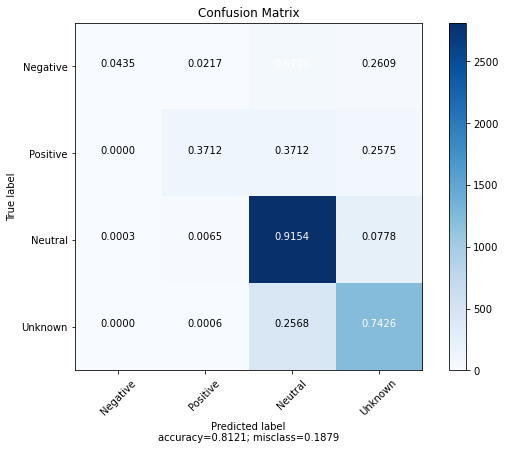

In [16]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['Negative', 'Positive', 'Neutral' , 'Unknown'],
                      title        = "Confusion Matrix")


So, our first model with minimal cleanup isn't too bad!  Accuracy about .81.  Unfortunately, this appears to be best at predicting tweets that have no sentiment. Let's just run this using 2 classes and see if that improves anything.

In [17]:
# only fetching rows that are labelled as positive or negative, no neutral or unknonw
pos_neg =  pd.read_sql("""
                    SELECT tweet_text as text, is_there_an_emotion_directed_at_a_brand_or_product as emotion
                    FROM tweets
                    WHERE tweet_text != 'None'
                    AND is_there_an_emotion_directed_at_a_brand_or_product IN ('Positive emotion','Negative emotion')
                    """,con)

X = pos_neg.text.astype('str')
y = pos_neg.emotion

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

mnb.fit(X_t_vec, y_t)

prior_0 = y_t.value_counts()['Negative emotion']/len(y_t)
prior_1 = y_t.value_counts()['Positive emotion']/len(y_t)
print(prior_0, prior_1)
print(np.log(prior_1))

0.1568922305764411 0.8431077694235589
-0.17066048879107043


In [18]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9413533834586466
[[ 208  105]
 [  12 1670]]


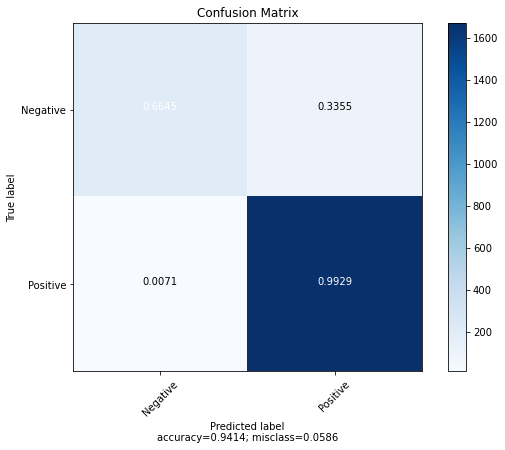

In [19]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

This looks much better, a fairly large improvement (.81 to .94).  We are still better at correctly predicting positive sentiment, but using this binomial model to iterate on should give us better results.

# Model Iteration 

In [44]:
# Creating new dataframe containing only positive or negative labelled tweets and no retweets


con = sl.connect('tweets')
corpus2 = pd.read_sql("""
                    SELECT tweet_text as text, is_there_an_emotion_directed_at_a_brand_or_product as emotion
                    FROM tweets
                    WHERE tweet_text != 'None'
                    AND is_there_an_emotion_directed_at_a_brand_or_product IN ('Positive emotion','Negative emotion')
                    AND tweet_text NOT like 'RT%'
                    """,con)
corpus2.head()

final = corpus2

X = final.text.astype('str')
y = final.emotion

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size=.25)

preprocess(final)
tokenization_w(final)

[['text'], ['emotion']]

In [45]:
#initial cleaning step repeated 

final["text"] = final["emotion"].apply(lambda x: clean_text(x))

In [46]:
#update stop words to exclude the top 20 words in our distribution - this included words like 'sxsw' and product names 

sw = stopwords.words('english')
sw.extend(["sxsw","mention","link","ipad","rt","apple","google","iphone",
                  "quot","store","app","new","get","austin","pop","amp","android","launch","go","open"] )
sw[-10:]

token_docs = [doc_preparer(doc, sw) for doc in X_train]
token_docs[0]

'know late game really dig flipboard'

In [47]:
#update train_text split with newly cleaned text

X_t, X_val, y_t, y_val = train_test_split(token_docs, y_train, test_size=.25, random_state=42)

cv = CountVectorizer()

X_t_vec = cv.fit_transform(X_t)
X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(cv.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)
X_t_vec

,aapl,abacus,abandon,able,absolute,absolutely,abuzz,acc,access,accessory,...,ze,zelda,zeldman,zero,zgd,zimride,zing,zip,zombie,zomg
2289,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1843,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2156,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
968,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2163,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our new dataframe is only 3370 columns, compared to over 6k columns in our first model.  This should give us better results

In [49]:
mnb.fit(X_t_vec, y_t)

prior_0 = y_t.value_counts()['Negative emotion']/len(y_t)
prior_1 = y_t.value_counts()['Positive emotion']/len(y_t)

print(prior_0, prior_1)
print(np.log(prior_1))

0.16883116883116883 0.8311688311688312
-0.18492233849401193


In [50]:
y_hat = mnb.predict(X_t_vec)
print(accuracy_score(y_t, y_hat))
print(confusion_matrix(y_t,y_hat))

0.9567099567099567
[[ 212   61]
 [   9 1335]]


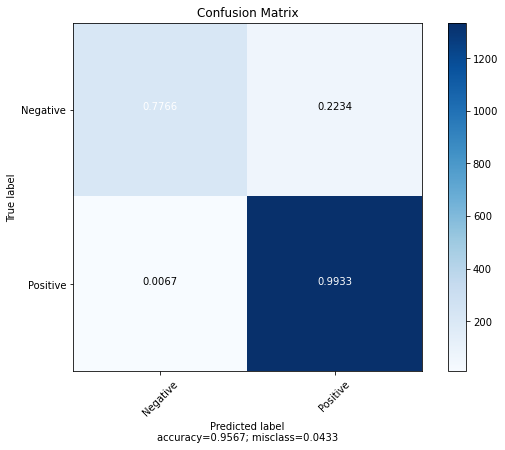

In [51]:
plot_confusion_matrix(cm = np.array(confusion_matrix(y_t,y_hat)), 
                      normalize    = True,
                      target_names = ['Negative', 'Positive'],
                      title        = "Confusion Matrix")

accuracy did improve, we are now at .96, so slight improvement from .94.  As with the first model we are still better at predicting positive sentiment, which is largely due to a class imbalance

# Final Model Interpretation

In our final model, we improved the accuracy score - though by a fairly small measure.  This would be a useable model for our purposes, however instead of identifying negative sentiment, we would want to flag tweets that were not identified as positive.

# Conclusion

The dataset used for this project was probably not the best one to use.  We had a very large class imbalance, both with product/brand that the tweet was directed at, and the sentiment in the tweet.  The other issue with this dataset is the way the sentiment was labelled.  This was crowdsourced, and the participants were to determine if a tweet was positive or negative, and then if they saw sentiment they were to identify the product.  There are a few problems with this process.  
It is unclear how each tweet was defined as positive or negative - it is also unclear how many users had to rate each tweet.  We quickly ran a polarity score (this uses a prescored dictionary to determine how positive or negative a phrase is https://planspace.org/20150607-textblob_sentiment/) and many tweets that were rated by users did not align with the polarity score. Because the tweets still contained the product/brand there was likely some bias introduced from the raters based on their own product preference.  

"Android maintained its position as the leading mobile operating system worldwide in December 2019, controlling the mobile OS market with a 74.13 percent share. Google Android and Apple iOS jointly possess almost 99 percent of the global market share." - https://www.statista.com/statistics/272698/global-market-share-held-by-mobile-operating-systems-since-2009/

In addition, the tweets appear to have all been generated at a specific event - namely the SXSW festival that takes place in Austin, TX every year.  This festival began as a music festival and has since grown to include film and other interactive conferences.  Again here we are likely to have some real biases as the tweets appear to be have been generated by a small, non-random group of users.

The dataset used is far too specific to generalize to any other dataset.

# Further exploration

It would be beneficial to explore this model on a different twitter dataset, and apply sentiment polarity analysis to them - in the dataset used here, the polarity scores did not appear to match up with the crowd-sourced sentiment tag. In addition, it would be interesting to see how other models handle this same text data.  